# Hierarchical Clustering of Lung Cancer Coabundance Networks

Depndencies are hell for this package so we recommend just running inside a container.

To run jupyter notebooks from inside the docker image, you need to forward the necessary ports to the container, so that your native browser can connect to it at http://localhost:8888/. You need first to start an interactive shell session

```bash
docker run -p 8888:8888 -p 6006:6006 -it -u user -w /home/user \
    tiagopeixoto/graph-tool bash
```

and then start the notebook server

```bash
jupyter notebook --ip 0.0.0.0
```

Or if you are using dev containers in vs code just choose the container for umage you once ran. It will save you the time of installing al the dev dependencies from vscode. Beware if you are in root you have to add the `--allow-root` flag.

In [1]:
import numpy as np
from IPython.display import Image

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

plt.switch_backend("cairo")

import networkx as nx
import graph_tool.all as gt



(ipykernel_launcher.py:8045): dbind-WARNING **: 19:32:05.792: Couldn't connect to accessibility bus: Failed to connect to socket /tmp/dbus-HPD6DPX1NH: Connection refused


In [138]:
# ! pacman -S python-pip
! pacman -S --noconfirm python-networkx

resolving dependencies...
looking for conflicting packages...

Package (1)            New Version  Net Change  Download Size

extra/python-networkx  3.3-2         22.61 MiB       3.16 MiB

Total Download Size:    3.16 MiB
Total Installed Size:  22.61 MiB

:: Proceed with installation? [Y/n] 
:: Retrieving packages...
 python-networkx-3.3-2-any downloading...
checking keyring...
checking package integrity...
loading package files...
checking for file conflicts...
:: Processing package changes...
installing python-networkx...
Optional dependencies for python-networkx
    python-lxml: for GraphML XML format
    python-pydot: for graph drawing and graph layout algorithms in pure Python
    via GraphViz
    python-pygraphviz: for graph drawing and graph layout algorithms with
    bindings to GraphViz
    python-sympy: for polynomial algorithms
:: Running post-transaction hooks...
(1/1) Arming ConditionNeedsUpdate...


In [177]:
from matplotlib.lines import Line2D

net_folder = '/root/host_home/luca/outputARACNE/'

# Define colors for different cell categories
color_map = {
    'immune adaptive': 'lightgreen',
    'immune native': 'blue',
    'immune both': 'purple',
    'stromal': '#D2B48C',
    'epithelial': 'orange',
    'tumoral': 'red'
}

# Define cell categories
cell_categories = {
    'immune adaptive': ['T cell CD8 activated', 'T cell CD4', 'B cell', 'B cell dividing', 'T cell regulatory', 'T cell CD8 effector memory',
                         'T cell CD8 activated', 'cDC2', 'T cell CD8 terminally exhausted', 'T cell CD4 dividing', 'T cell CD8 dividing', 'T cell CD8 naive'],
    'immune both': ['Mast cell', 'myeloid dividing', 'pDC', 'DC mature', 'T cell NK-like', "Plasma cell", "Plasma cell dividing"],
    'immune native': ['Monocyte classical', 'Monocyte non-classical', 'NK cell', 'Macrophage', 'Macrophage alveolar', 'NK cell dividing', 'Neutrophils', 'cDC1'],
    'stromal': ['Fibroblast peribronchial', 'Fibroblast alveolar', 'Endothelial cell venous', 'Endothelial cell lymphatic',
                 'Endothelial cell capillary', 'Smooth muscle cell', 'Pericyte', 'Fibroblast adventitial', 'stromal dividing'],
    'epithelial': ['Alveolar cell type 1', 'Alveolar cell type 2', 'Ciliated', 'Club', 'transitional club/AT2', 'ROS1+ healthy epithelial'],
    'tumoral': ['Tumor cells LUAD', 'Tumor LUAD_mixed', 'Tumor LUAD_transitional', 'Tumor LUAD_LUSC', 'Tumor LUAD_mitotic', 'Tumor LUAD_LUSC_mitotic', 'Tumor LUAD_mainly1']
}

cell_type_to_category = {}
for category, cell_types in cell_categories.items():
    for cell_type in cell_types:
        cell_type_to_category[cell_type] = category


# Define function to get state from file
def get_state_from_file(time, net_folder=net_folder, is_networkx=False, remove_neg=False):

    if not is_networkx:
        file_path = f'{net_folder}/net{time}.txt'
        g = gt.load_graph_from_csv(file_path, csv_options={"delimiter":'\t'}, eprop_types=["float"], eprop_names=['MI',])
    else:
        file_path = f'{net_folder}/net{time}_MI_pearson.txt'
        g = gt.load_graph_from_csv(file_path, csv_options={"delimiter":'\t'},
                                    eprop_types=[ "float", "float", "float", "float", "string"],
                                    eprop_names=['MI', 'pvals', 'pearson', 'pvalue', 'sign'])

    # Remove repeated edges VERY STRANGE WITH REPEATED EDGES THERE IS MORE STRUCTURE, THAT MAY ALSO BE BECAUSE SOME EDGES ARE NOT REPEATED AND SOME ARE
    edges = list(g.edges())
    edge_set = set()
    for edge in edges:
        if (edge.source(), edge.target()) in edge_set or (edge.target(), edge.source()) in edge_set:
            g.remove_edge(edge)
        else:
            edge_set.add((edge.source(), edge.target()))

    if remove_neg:
        edges = list(g.edges())
        for e in edges:
            if g.ep.sign[e] == 'negative_significant':
                g.remove_edge(e)

    print(g)
    state = gt.minimize_nested_blockmodel_dl(g)

    entropy_1 = state.entropy()

    entropy_2 = gt.mcmc_anneal(state, beta_range=(1, 20), niter=1500,
                                mcmc_equilibrate_args=dict(force_niter=20))

    print("Without annealing: " + str(entropy_1))
    print("With annealing: " + str(entropy_2) )

    return state, g


def paint_net_from_state(state, g, time, width_divisor=16, margin=0.25, remove_neg=False):

    # Assign cell category and color
    g.vp.cat = g.new_vertex_property("string")
    g.vp.color = g.new_vertex_property("string")
    for v in g.vertices():
        g.vp.cat[v] = cell_type_to_category[g.vp.name[v]]
        g.vp.color[v] = color_map[g.vp.cat[v]]

    e_width = g.new_edge_property("float")
    e_width.a = g.ep.MI.a/width_divisor

    e_gradient = g.new_edge_property("vector<float>")
    for e in g.edges():
        v = e.source()
        rgb = list(mcolors.to_rgba(g.vp.color[v]))
        e_gradient[e] = [   0, rgb[0], rgb[1], rgb[2], 0.7,
                            1, rgb[0], rgb[1], rgb[2], 0.2
                        ]
        
    e_dash = g.new_edge_property("vector<float>")
    for e in g.edges():
        e.sign = g.ep.sign[e]
        if e.sign == 'positive_significant':
            e_dash[e] = [ 3,3,3 ]
        elif e.sign =='negative_significant':
            e_dash[e] = [ 10,10,10 ]
            # e_width[e] = e_width[e]*10
        else:
            e_dash[e] = [ 1,0, 0 ]

    fig, ax = plt.subplots(figsize=(12, 10))
    a = state.draw( #https://graph-tool.skewed.de/static/doc/autosummary/graph_tool.draw.graph_draw.html 
                vertex_fill_color=g.vp.color,
                edge_pen_width=e_width,
                #  vertex_halo_color=g.vp.color,
                vertex_text=g.vp.name,
                vertex_text_size=8,
                edge_dash_style=e_dash,
                vertex_text_position='centered',
                edge_gradient = e_gradient,
                vertex_pen_width=0.0,
                # vertex_size=gt.prop_to_size(g.degree_property_map("total"), mi=0.01, ma=0.02, power=1),
                mplfig=ax,
    )
    a[0].fit_view(margin=margin, yflip=True)
    ax.set_title(time)
    ax.set_axis_off()

    # Add legend to the plot
    handles = []
    for category, color in color_map.items():
        handles.append(mpatches.Patch(color=color, label=category))
    if not remove_neg:
        neg_dash = Line2D([], [], color='black', linestyle='--', label='negative_pearson')
        handles.append(neg_dash)
    pos_dash = Line2D([], [], color='black', linestyle='dotted', label='positve_pearson')
    handles.append(pos_dash)
    ax.legend(handles=handles, bbox_to_anchor=(1, 0.5), loc='upper left')
    plt.subplots_adjust(right=0.8, left=0.01, bottom=0.01, top=0.95)  # Adjust right margin for the legend


    fig.savefig(f"{net_folder}/graph_{time}.png")
    plt.close(fig)

    return Image(filename=f"{net_folder}/graph_{time}.png")

## Get state

In [88]:
state_early, g_early = get_state_from_file("I-II_leiden", is_networkx=True)

state_late, g_late = get_state_from_file("III-IV_leiden", is_networkx=True)

# Takes 2m12 in docker container

<Graph object, undirected, with 40 vertices and 162 edges, 1 internal vertex property, 5 internal edge properties, at 0x7f62b2c41490>
Without annealing: 412.2986785789716
With annealing: (412.2986785789716, 6413330, 32008)


We used to have repeted edges and this gave us mch more structure. We need to analyze why if this is valid, and why ARACNE does that.

It must be because of the bootstrapping there is a slight difference.... still more exploration could give us some jsutifcation to tkae the repeated edges.

In [165]:
state_early_noneg, g_early_noneg = get_state_from_file("I-II_leiden", is_networkx=True, remove_neg=True)

state_late_noneg, g_late_noneg = get_state_from_file("III-IV_leiden", is_networkx=True, remove_neg=True)

<Graph object, undirected, with 47 vertices and 183 edges, 1 internal vertex property, 5 internal edge properties, at 0x7f62b2d22ae0>


Without annealing: 496.00842150900155
With annealing: (496.08814238934866, 30907926, 418744)
<Graph object, undirected, with 40 vertices and 159 edges, 1 internal vertex property, 5 internal edge properties, at 0x7f62b19d5550>
Without annealing: 411.0717019650185
With annealing: (411.0717019650185, 6420933, 28025)


## Paint networks

/usr/lib/python3.12/site-packages/graph_tool/draw/cairo_draw.py:545: UserWarning: Unknown edge attribute: text_size
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)


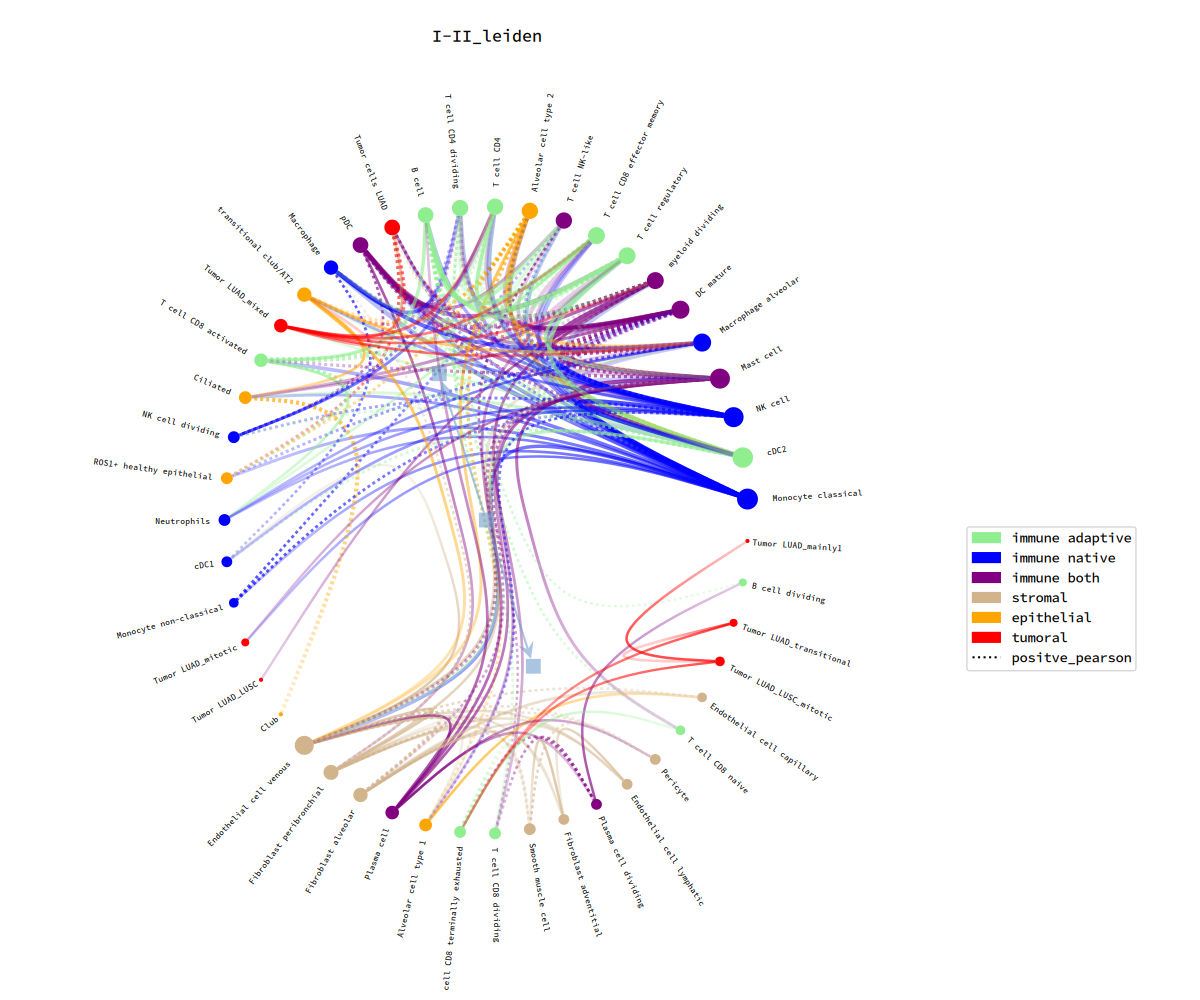

In [178]:
paint_net_from_state(state_early_noneg, g_early_noneg, "I-II_leiden", remove_neg=True)

/usr/lib/python3.12/site-packages/graph_tool/draw/cairo_draw.py:545: UserWarning: Unknown edge attribute: text_size
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)


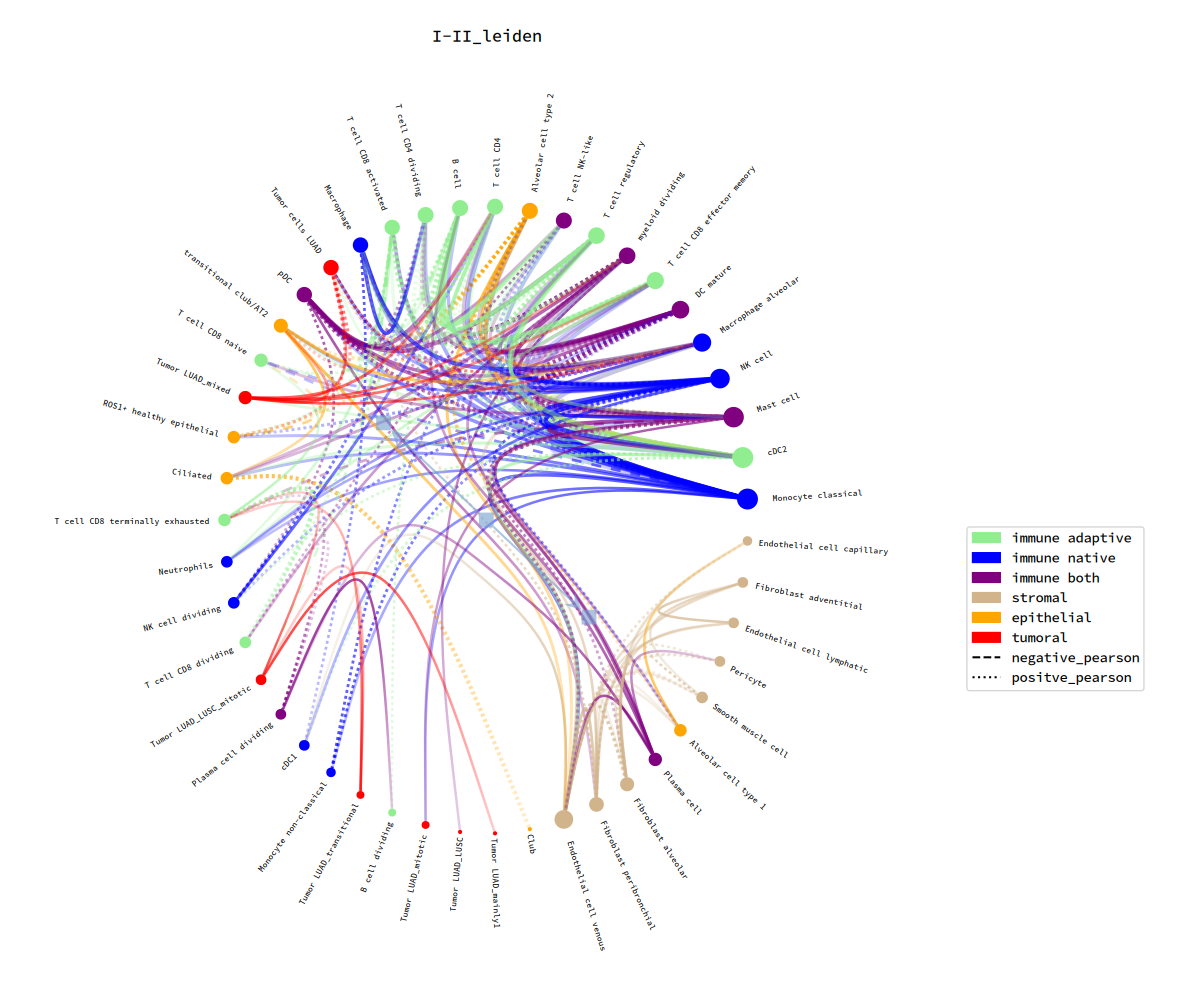

In [161]:
paint_net_from_state(state_early, g_early, "I-II_leiden")

<EdgePropertyMap object with value type 'vector<double>', for Graph 0x7ff3d3b2b1a0, at 0x7ff407f34d10>


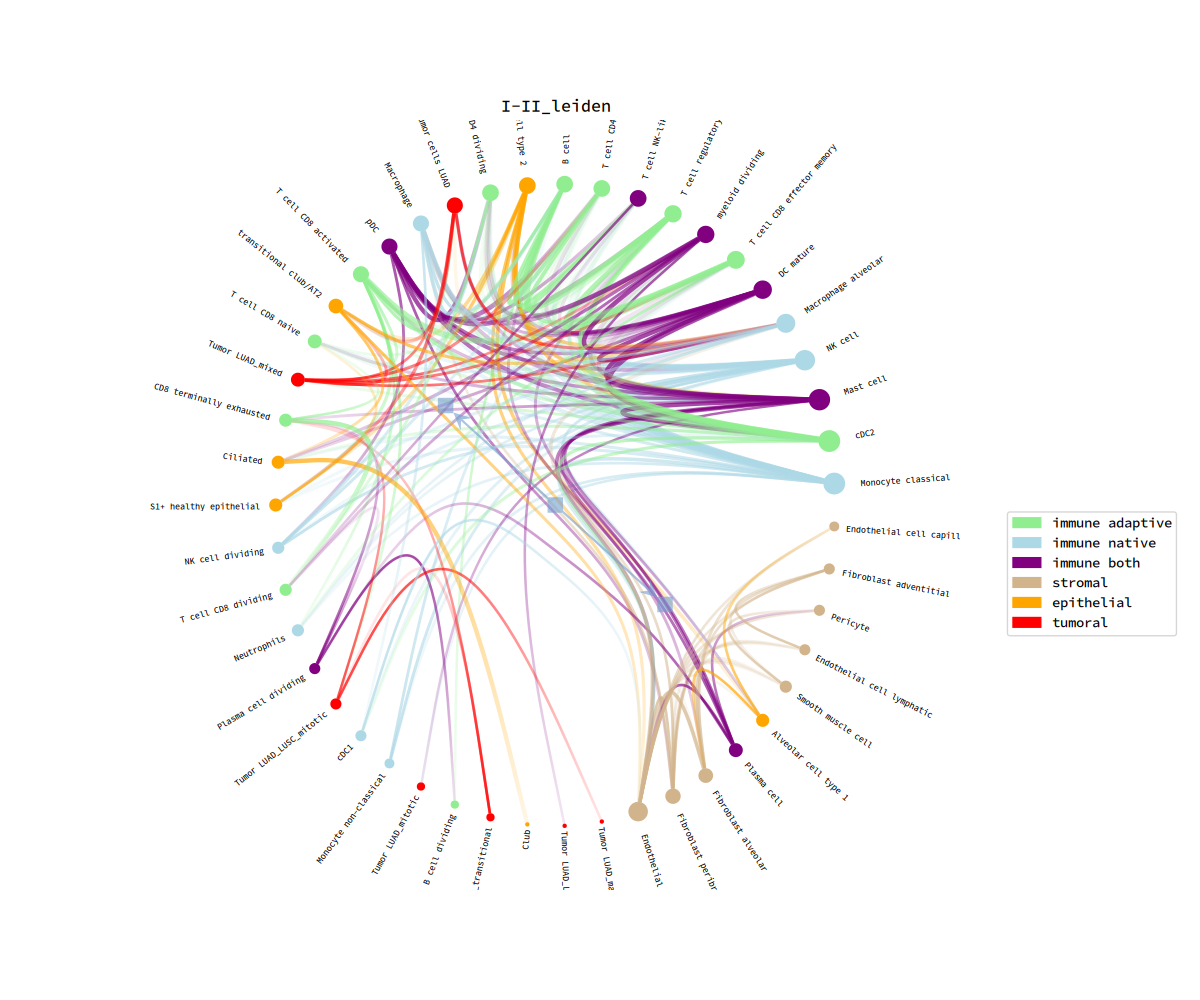

In [129]:
paint_net_from_state(state_early, g_early, "I-II_leiden")

/usr/lib/python3.12/site-packages/graph_tool/draw/cairo_draw.py:545: UserWarning: Unknown edge attribute: text_size
  warnings.warn(f"Unknown {kind} attribute: " + str(k), UserWarning)


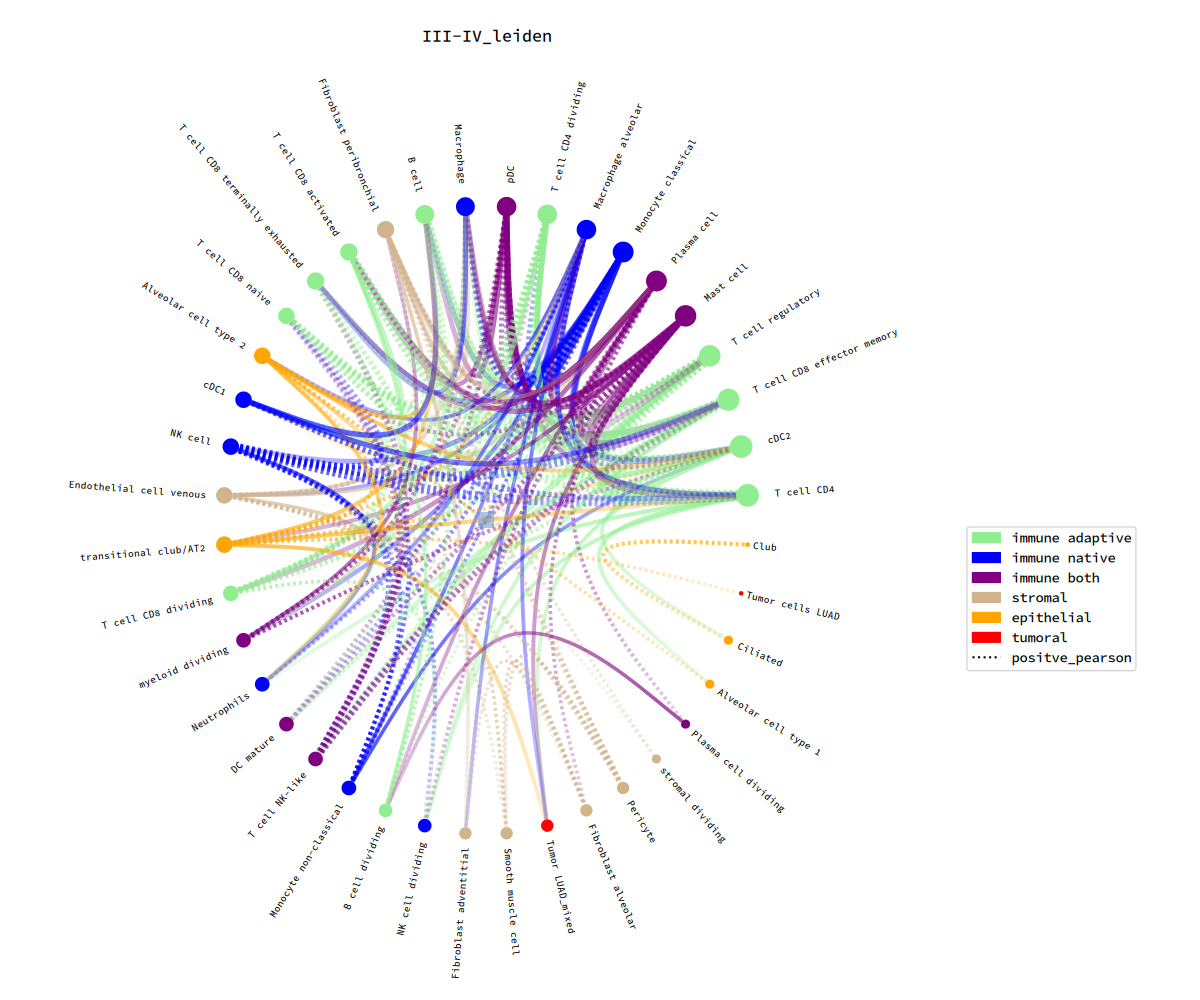

In [179]:
paint_net_from_state(state_late_noneg, g_late_noneg, "III-IV_leiden", width_divisor=22, remove_neg=True)

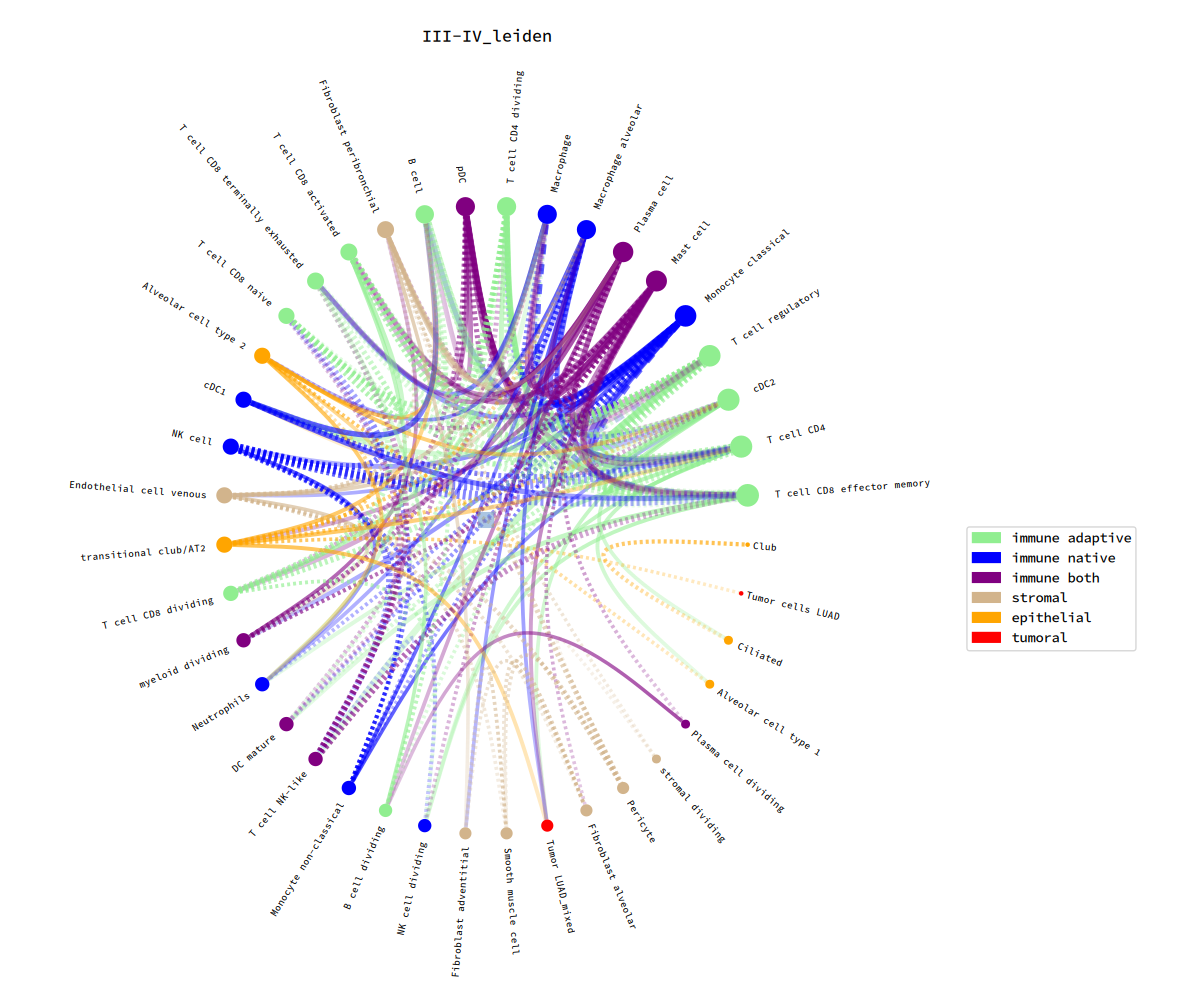

In [155]:
paint_net_from_state(state_late, g_late, "III-IV_leiden", width_divisor=22)